# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5))

50-element Vector{Int64}:
  1
  1
  1
 -1
  1
  1
  1
  1
 -1
 -1
  ⋮
 -1
  1
 -1
  1
 -1
 -1
 -1
  1
 -1

### We create a function to visualize the data

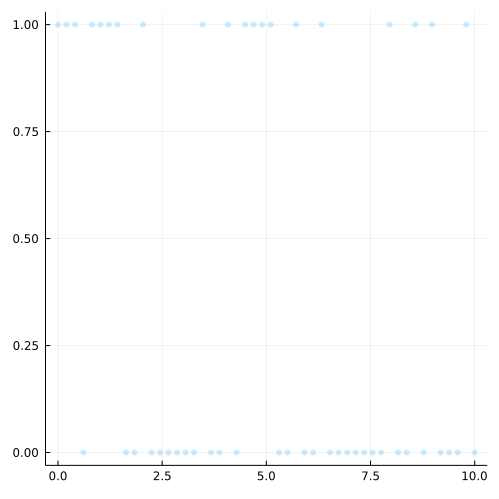

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  0.856210 seconds (1.86 M allocations: 98.368 MiB, 99.51% compilation time)


(Variational Gaussian Process with a BernoulliLikelihood{GPLikelihoods.LogisticLink}(GPLikelihoods.LogisticLink(LogExpFunctions.logistic)) infered by Analytic Variational Inference , (local_vars = (c = [1.1331854148216856, 1.1437806037107898, 1.1316655371284234, 1.088312427763419, 1.0092925683375737, 0.8967626096623932, 0.7651843986740677, 0.6487008913226384, 0.6034962984513987, 0.6670742548830478  …  0.959739607288851, 0.8887061135730621, 0.8372636935828858, 0.8052988809848065, 0.7896737478699134, 0.7871233508453355, 0.7942313077419655, 0.8084246309349351, 0.8276383960769996, 0.8505289413878866], θ = [0.22628801393001607, 0.22589392160165955, 0.22634438239945381, 0.22793436998513908, 0.23073753657668591, 0.23449211818277468, 0.23847619391730449, 0.2415869222839704, 0.24267886418885332, 0.2411241709777877  …  0.23242728073577618, 0.23474924330067096, 0.23635159028890104, 0.2373116679309849, 0.23777069218528696, 0.23784496359904383, 0.23763751151625423, 0.23721902303052475, 0.2366436243

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:04:21
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:13
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:28
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:06
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:00:53
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:44
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:37
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:32
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:29
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:26
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:23
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:21
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[0.04547374197772869, 0.1161885694729542, 0.19018372815258167, 0.2545449409960766, 0.28877106257443147, 0.3113531511156117, 0.29551082378552734, 0.21681537857384997, 0.11187945991899154, -0.024743473638780822  …  -2.2792028393438395, -2.277972809285071, -2.1565686523149528, -1.911916171655351, -1.5698357254256088, -1.1467768629784425, -0.6941615192561681, -0.2907469652342171, 0.02500952785880728, 0.20556592526369055]]
 [[1.0367022653714166, 1.0160389778008683, 0.8057049037247201, 0.46616312728199305, 0.06541024178428068, -0.3551305553645554, -0.7605491759004861, -1.0892376565371613, -1.2733425840780668, -1.3014654725523722  …  -1.8541365213035603, -1.735435105031745, -1.612189148339647, -1.546125452257857, -1.508903498034171, -1.5420808552510403, -1.5779459566602587, -1.6185862922981311, -1.6488732659311838, -1.5751650253528937]]
 [[1.1314373924631722, 1.1835199950060893, 1.1437990248667842, 0.9680084006678434, 0.7099113378246341, 0.37509

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

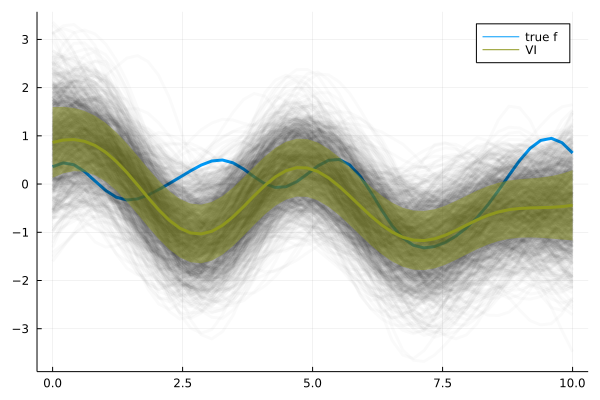

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

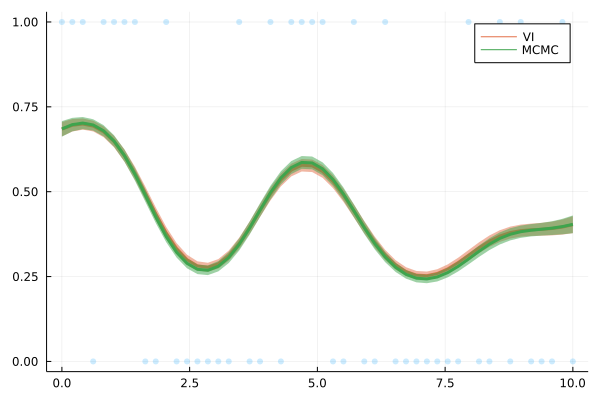

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*